# Cat vs. Dog Image Classification
## Exercise 1: Building a Convnet from Scratch

In this exercise, we will build a classifier model from scratch that is able to distinguish dogs from cats. We will follow these steps:

1. Explore the example data
2. Build a small convnet from scratch to solve our classification problem
3. Evaluate training and validation accuracy

Let's go!


## Explore the Example Data
Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.  
**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [25]:
!pip install zipfile36

In [26]:
import os
import zipfile36 as zipfile 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread
from PIL import Image
import tensorflow as tf
tf.__version__

'2.9.1'

In [28]:
os.getcwd()
base_dir = './'
os.chdir(base_dir)

In [31]:
# Let's find out the total number of cat and dog images in the `train` and `validation` directories:

# os.listdir()
os.listdir('train')
os.listdir('train/paper/')
os.listdir('train/rock/')
os.listdir('train/scissors/')

print('total training paper images:', len(os.listdir('train/paper')))
print('total training rock images:', len(os.listdir('train/rock')))
print('total validation scissors images:', len(os.listdir('train//scissors')))
print('total validation paper images:', len(os.listdir('validation/paper')))
print('total validation rock images:', len(os.listdir('validation/rock')))
print('total validation scissors images:', len(os.listdir('validation/scissors')))

total training paper images: 840
total training rock images: 840
total validation scissors images: 840
total validation paper images: 11
total validation rock images: 11
total validation scissors images: 11


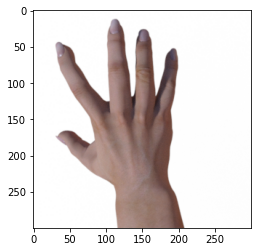

In [35]:
# Retourner ds 1 tableau numpy les pixels de l'image
paper1 = imread('./train/paper/paper01-052.png')
# train_dir+'/paper'+'/cat.0.jpg'
# paper1
# cat1.shape  #  shape  => les dimensions
plt.imshow(paper1)

'validation/paper/paper9.png'

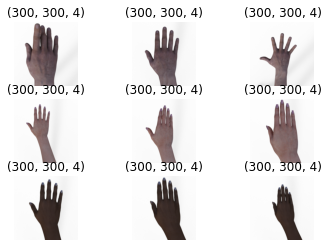

In [45]:
# For both cats and dogs, we have 1,000 training images and 500 test images.

# Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like.

# Une boucle pr afficher plusieurs images dans une figure

for i in range(9):
    plt.subplot(3, 3, i+1)
    filename = 'validation/' + 'paper/' + 'paper' + str(i+1) + '.png'
    image = imread(filename)
    plt.imshow(image)
    plt.title(image.shape)
    plt.axis('Off') # Don't show axes (or gridlines)
filename
# S : On constate que les images sont en mode paysage, mode portrait et de différentes tailles  
# => Ceci peut poser des Pb pour la perfermonce du classifieur. Il nous faut un classifieur robuste !

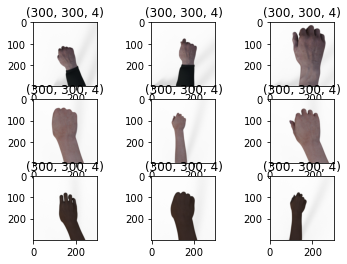

In [46]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    filename = 'validation/' + 'rock/' + 'rock' + str(i+1) + '.png'
    image = imread(filename)
    plt.imshow(image)
    plt.title(image.shape)

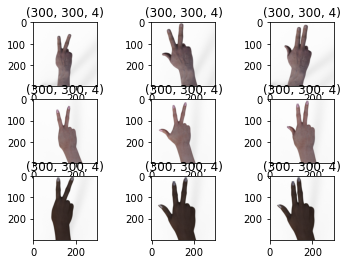

In [47]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    filename = 'validation/' + 'scissors/' + 'scissors' + str(i+1) + '.png'
    image = imread(filename)
    plt.imshow(image)
    plt.title(image.shape)

In [91]:
# Manip avec PIL : pkg Python de réf pr le traitement d'image
paper1 = Image.open('train/paper/paper01-001.png')
# paper1
# paper1.show()
# paper1.size
# paper1.mode
# paper1.format
# np.array(paper1)
# imread('train/paper/paper01-001.png')

# paper1 = tf.keras.preprocessing.image.load_img('train/paper/paper01-001.png')
# paper1
paper1_ = tf.keras.preprocessing.image.img_to_array(paper1)
paper1_

array([[[255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        ...,
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.]],

       [[255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        ...,
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.]],

       [[255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        ...,
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.]],

       ...,

       [[255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        ...,
        [253., 253., 253., 255.],
        [254., 254., 254., 255.],
        [254., 254., 254., 255.]],

       [[255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        .

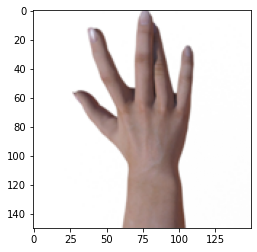

In [92]:
paper1sz = paper1.resize((150, 150))
# paper1sz
# paper1sz_ = tf.keras.preprocessing.image.img_to_array(paper1sz)
# paper1sz_
# paper1sz_sc = paper1sz_ * 1./255
# paper1sz_
tf.keras.preprocessing.image.array_to_img(paper1sz_sc)
plt.imshow(paper1sz_sc)

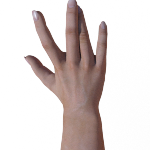

In [93]:
tf.keras.preprocessing.image.load_img('train/paper/paper01-003.png', target_size=(150, 150))

In [94]:
# Q : Comment  injecter les images depuis l'arborescence des dossiers sources dans le CNN (sans passer par des étapes manuelles - preprocessing : normalisation, resizing, augmentation, ...) ?

# R : Ns devons construire 'train_datagen' et 'val_datagen' à l'aide de tf.keras.preprocessing.image.ImageDataGenerator

# Explication :
# Cette classe permet de :
	# i) lire les images depuis l'arborescence,
	# ii) Convertir les images en tensors float32,
	# iii) Injecter avec les labels associés ds le CNN suivant un batch (par ex 20) après les avoir resizer (taille 150x150).


# Par la suite, nous pouvons utiliser les méthodes .flow(), .flow_from_directory(), .flow_from_dataframe()
# Ces generators peuvent être utilisés dans les modeles convolutifs : fit_generator, evaluate_generator, predict_generator

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [196]:
train_gen = train_datagen.flow_from_directory(
    'train', # path du train 
    target_size=(150, 150), 
    batch_size=3, 
    class_mode='categorical', 
    seed = 42
)

Found 2520 images belonging to 3 classes.


In [197]:
# train_gen.n 	# nb d'images
# S : 2000
# train_gen.class_indices
# {'paper': 0, 'rock': 1,'scissors': 2}
# val_gen.classes 
# train_gen.labels 	# cette info est la plus intéressante parce que ns allons l'utiliser pr construire la matrice de confusion
# train_gen.labels.shape 	# cette info est la plus intéressante parce que ns allons l'utiliser pr construire la matrice de confusion
# array([0, 0, 0, ..., 1, 1, 1])

# train_gen.batch_size 	# nb d'images à envoyer (lot)
# 20

train_gen.directory
train_gen.labels

array([0, 0, 0, ..., 2, 2, 2])

In [198]:
val_gen = val_datagen.flow_from_directory(
    'validation', 
    target_size=(150, 150), 
    batch_size=3, 
    class_mode='categorical',
    seed = 42
)

Found 33 images belonging to 3 classes.


In [199]:
type(val_gen)

keras.preprocessing.image.DirectoryIterator

In [200]:
train_batches = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory='train', target_size=(224,224), class_mode='categorical', batch_size=10)

Found 2520 images belonging to 3 classes.


In [201]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [202]:
# Visualiser les images resizés et rescalés
imgs, labels = next(train_batches)
# labels
imgs
# len(train_batches)

array([[[[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [150.061  , 137.22101, 130.32   ],
         ...,
         [150.061  , 137.22101, 130.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [150.061  , 137.22101, 130.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        ...,

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

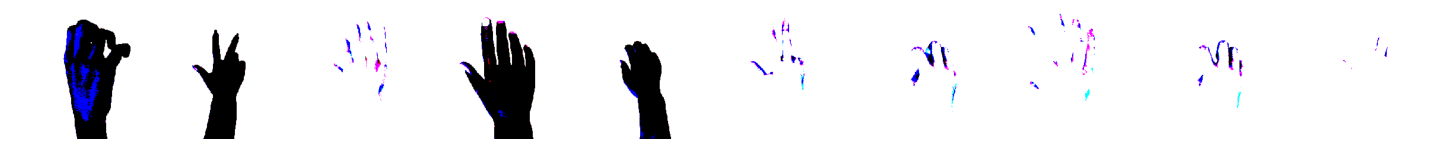

In [203]:
plotImages(imgs)

In [204]:
# Visualiser les images resizés et rescalés
imgs, labels = next(train_gen)
# labels
# imgs
len(train_gen)

840

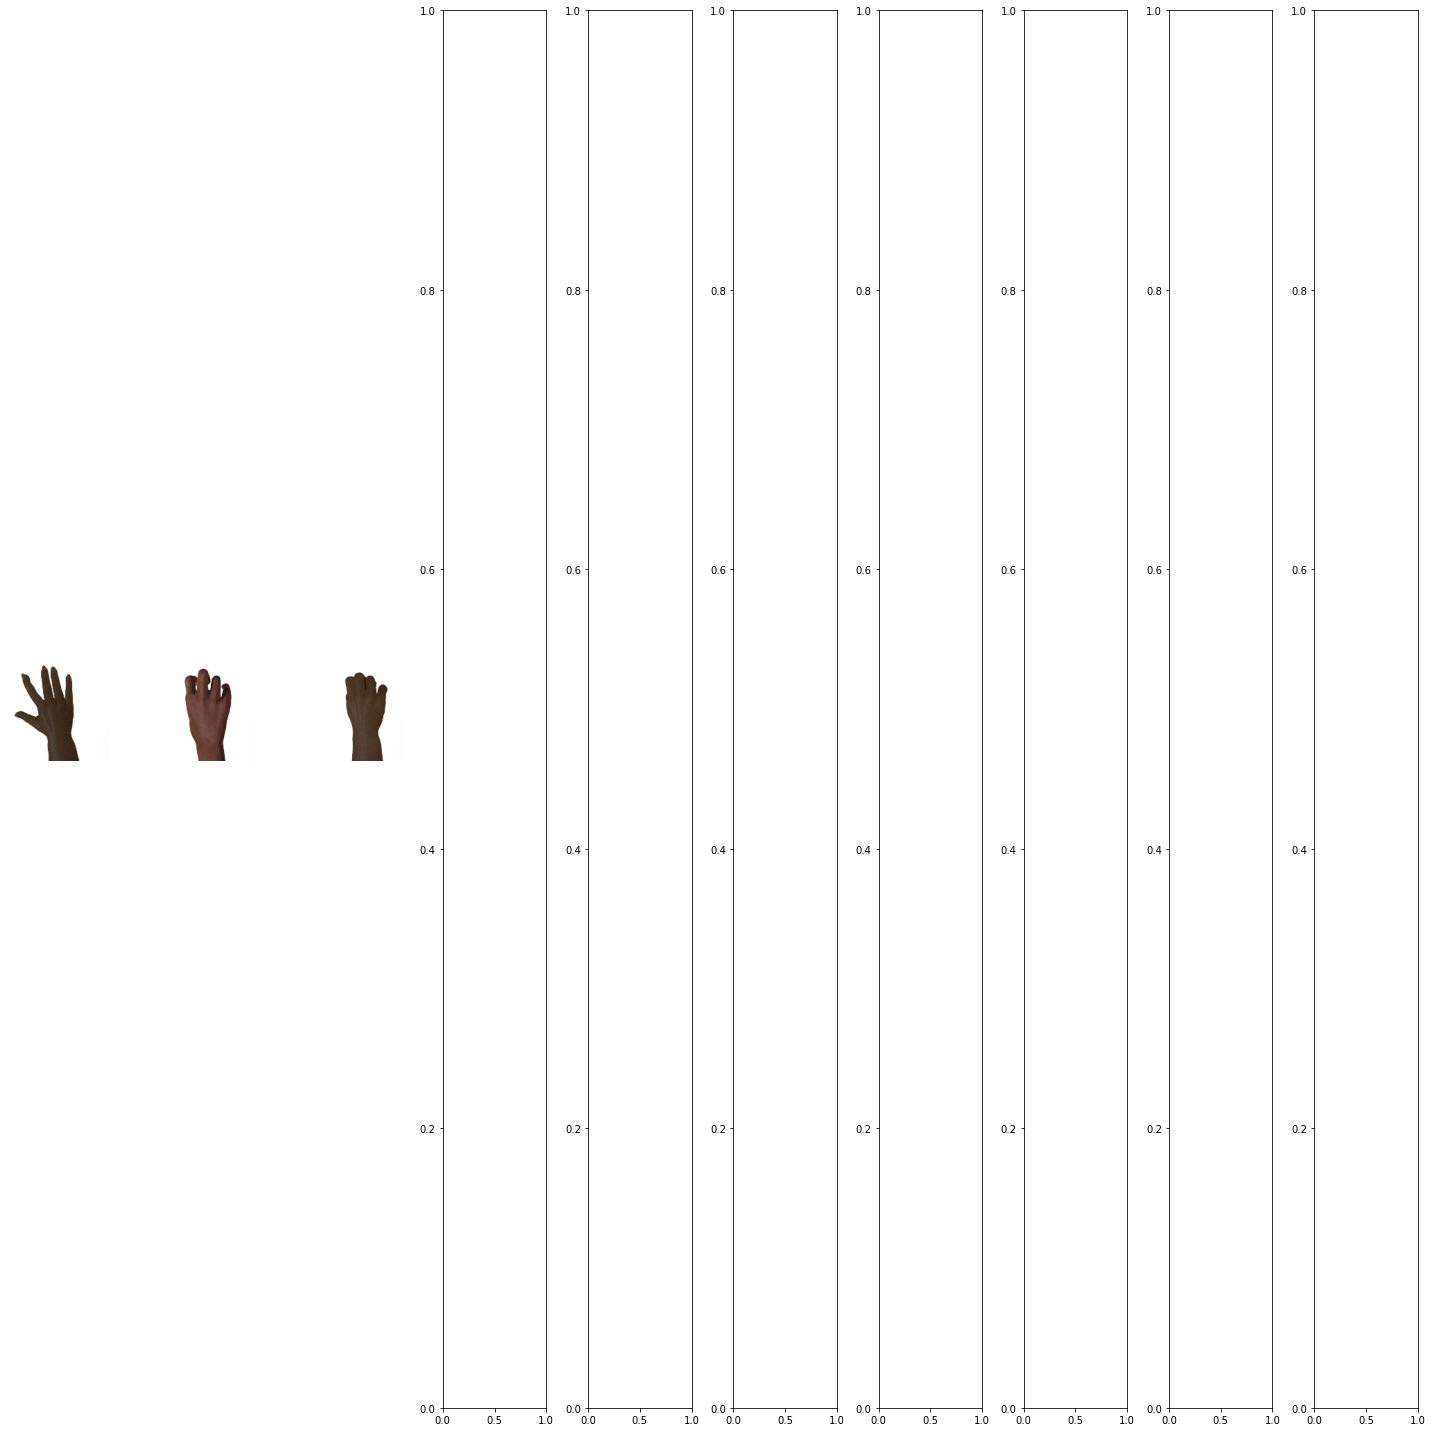

In [205]:
plotImages(imgs)

In [206]:
labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

# Building a Small Convnet from Scratch to Get to 72% Accuracy

The images that will go into our convnet are 150x150 color images.

Let's code up the architecture. We will stack 3 {convolution + relu + maxpooling} modules. Our convolutions operate on 3x3 windows and our maxpooling layers operate on 2x2 windows. Our first convolution extracts 16 filters, the following one extracts 32 filters, and the last one extracts 64 filters.

**NOTE**: This is a configuration that is widely used and known to work well for image classification. Also, since we have relatively few training examples (1,000), using just three convolutional modules keeps the model small, which lowers the risk of overfitting.

In [207]:
# Ds le cadre du df data2 : x1, x2 comme features
inputs = tf.keras.layers.Input(shape=(2, ))

In [212]:
# Maintenant, ns travaillons sur des images, ns indiquons 
# les dim de l'image => (heigth, width, mode)
# del model

inputs = tf.keras.layers.Input(shape=(150, 150, 3))

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 64)        1849

We'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent]  because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [213]:
model.compile(loss='categorical_crossentropy', metrics=['acc'], 
              optimizer='rmsprop')

In [214]:
history = model.fit(train_gen, epochs=2, steps_per_epoch=100, 
                   validation_data=val_gen, validation_steps=50)

Epoch 1/2
100/100 [==============================] - 22s 214ms/step - loss: 0.9817 - acc: 0.6733 - val_loss: 1.0948 - val_acc: 0.5758
Epoch 2/2
100/100 [==============================] - 21s 209ms/step - loss: 0.2989 - acc: 0.9033


In [ ]:
def diagnostic_learning_curves():
  # Retrieve a list of accuracy results on training and validation data
  # sets for each training epoch
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  # Retrieve a list of list results on training and validation data
  # sets for each training epoch
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get number of epochs
  epochs = range(len(acc))

  # Plot training and validation accuracy per epoch
  plt.plot(epochs, acc)
  plt.plot(epochs, val_acc)
  plt.title('Training and validation accuracy')

  plt.figure()

  # Plot training and validation loss per epoch
  plt.plot(epochs, loss)
  plt.plot(epochs, val_loss)
  plt.title('Training and validation loss')

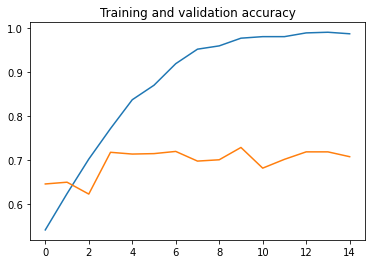

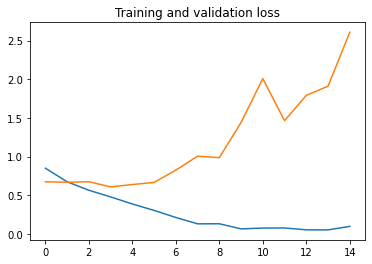

In [ ]:
diagnostic_learning_curves()

As you can see, we are **overfitting** like it's getting out of fashion. Our training accuracy (in blue) gets close to 100% (!) while our validation accuracy (in green) stalls as 70%. Our validation loss reaches its minimum after only five epochs.

Since we have a relatively small number of training examples (2000), overfitting should be our number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three images of people who are sailors, and among them the only person wearing a cap is a lumberjack, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Overfitting is the central problem in machine learning: given that we are fitting the parameters of our model to a given dataset, how can we make sure that the representations learned by the model will be applicable to data never seen before? How do we avoid learning things that are specific to the training data?

In the next exercise, we'll look at ways to prevent overfitting in the cat vs. dog classification model.

### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import Model

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(inputs, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

NameError: ignored

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.

# Cat vs. Dog Image Classification
## Exercise 2: Reducing Overfitting
**_Estimated completion time: 30 minutes_**

In this notebook we will build on the model we created in Exercise 1 to classify cats vs. dogs, and improve accuracy by employing a couple strategies to reduce overfitting: **data augmentation** and **dropout**. 

We will follow these steps:

1. Explore how data augmentation works by making random transformations to training images.
2. Add data augmentation to our data preprocessing.
3. Add dropout to the convnet.
4. Retrain the model and evaluate loss and accuracy. 

Let's get started!  

## Exploring Data Augmentation

Let's get familiar with the concept of **data augmentation**, an essential way to fight overfitting for computer vision models.

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that at training time, **our model will never see the exact same picture twice**. This helps prevent overfitting and helps the model generalize better.

This can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` instance. Let's get started with an example:

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the [Keras documentation](https://keras.io/preprocessing/image/). Let's quickly go over what we just wrote:

- `rotation_range` is a value in degrees (0–180), a range within which to randomly rotate pictures.
- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- `shear_range` is for randomly applying shearing transformations.
- `zoom_range` is for randomly zooming inside pictures.
- `horizontal_flip` is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images. First let's set up our example files, as in Exercise 1.

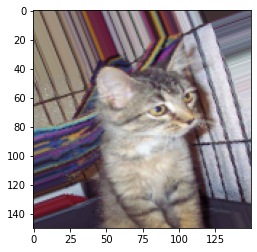

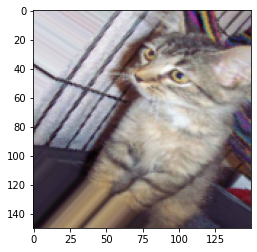

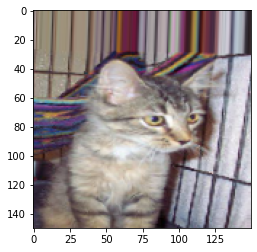

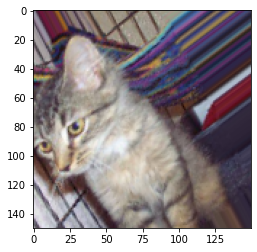

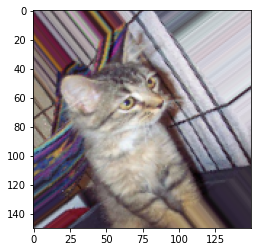

In [53]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

# img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img('train/cats/cat.2.jpg', target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

## Add Data Augmentation to the Preprocessing Step

Now let's add our data-augmentation transformations from [**Exploring Data Augmentation**](#scrollTo=E3sSwzshfSpE) to our data preprocessing configuration:

In [54]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        "train",  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        'validation',
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


If we train a new network using this data augmentation configuration, our network will never see the same input twice. However the inputs that it sees are still heavily intercorrelated, so this might not be quite enough to completely get rid of overfitting.

In [55]:
inputs = tf.keras.layers.Input(shape=(150, 150, 3))
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        1849

In [56]:
model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer='rmsprop')

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/30
100/100 - 66s - loss: 0.8094 - acc: 0.5465 - val_loss: 0.7293 - val_acc: 0.5000 - 66s/epoch - 663ms/step
Epoch 2/30
100/100 - 66s - loss: 0.6875 - acc: 0.6100 - val_loss: 0.6467 - val_acc: 0.5960 - 66s/epoch - 660ms/step
Epoch 3/30
100/100 - 66s - loss: 0.6655 - acc: 0.6330 - val_loss: 0.6185 - val_acc: 0.6600 - 66s/epoch - 657ms/step
Epoch 4/30
100/100 - 66s - loss: 0.6616 - acc: 0.6275 - val_loss: 0.6005 - val_acc: 0.6680 - 66s/epoch - 657ms/step
Epoch 5/30
100/100 - 65s - loss: 0.6247 - acc: 0.6510 - val_loss: 0.5900 - val_acc: 0.6860 - 65s/epoch - 653ms/step
Epoch 6/30
100/100 - 65s - loss: 0.6276 - acc: 0.6705 - val_loss: 0.6024 - val_acc: 0.6480 - 65s/epoch - 651ms/step
Epoch 7/30
100/100 - 65s - loss: 0.6075 - acc: 0.6695 - val_loss: 0.5731 - val_acc: 0.6920 - 65s/epoch - 649ms/step
Epoch 8/30
100/100 - 65s - loss: 0.6100 - acc: 0.6755 - val_loss: 0.5953 - val_acc: 0.6780 - 65s/epoch - 649ms/step
Epoch 9/30
100/100 - 65s - loss: 0.5863 - acc: 0.7015 - val_loss: 0.7106

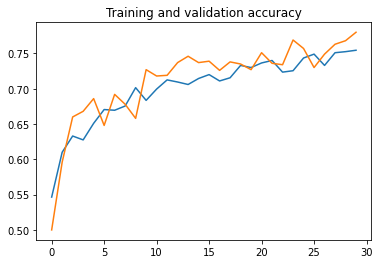

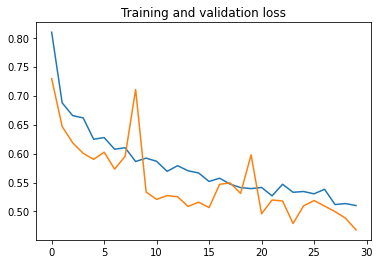

In [ ]:
diagnostic_learning_curves()

## Adding Dropout

Another popular strategy for fighting overfitting is to use **dropout**
Let's reconfigure our convnet architecture from Exercise 1 to add some dropout, right before the final classification layer

In [59]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])
model.summary() 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 64)        1849

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
## Retrain the Model

# With data augmentation and dropout in place, let's retrain our convnet model. This time, let's train on all 2,000 images available, for 30 epochs, and validate on all 1,000 validation images. (This may take a few minutes to run.) See if you can write the code yourself


WRITE CODE TO TRAIN THE MODEL ON ALL 2000 IMAGES FOR 30 EPOCHS, AND VALIDATE 
ON ALL 1,000 VALIDATION IMAGES

### Solution

Click below for the solution.

In [63]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/30
100/100 - 68s - loss: 0.8432 - acc: 0.5295 - val_loss: 0.6946 - val_acc: 0.5000 - 68s/epoch - 681ms/step
Epoch 2/30
100/100 - 67s - loss: 0.6887 - acc: 0.5770 - val_loss: 0.6298 - val_acc: 0.6620 - 67s/epoch - 665ms/step
Epoch 3/30
100/100 - 66s - loss: 0.6615 - acc: 0.6280 - val_loss: 0.7604 - val_acc: 0.5660 - 66s/epoch - 662ms/step
Epoch 4/30
100/100 - 66s - loss: 0.6460 - acc: 0.6335 - val_loss: 0.5987 - val_acc: 0.6790 - 66s/epoch - 664ms/step
Epoch 5/30
100/100 - 66s - loss: 0.6360 - acc: 0.6525 - val_loss: 0.5766 - val_acc: 0.6850 - 66s/epoch - 660ms/step
Epoch 6/30
100/100 - 66s - loss: 0.6087 - acc: 0.6780 - val_loss: 0.5721 - val_acc: 0.6900 - 66s/epoch - 663ms/step
Epoch 7/30
100/100 - 66s - loss: 0.6190 - acc: 0.6625 - val_loss: 0.5819 - val_acc: 0.6990 - 66s/epoch - 661ms/step
Epoch 8/30
100/100 - 67s - loss: 0.6038 - acc: 0.6780 - val_loss: 0.5390 - val_acc: 0.7330 - 67s/epoch - 671ms/step
Epoch 9/30
100/100 - 67s - loss: 0.5875 - acc: 0.6895 - val_loss: 0.5630

Note that with data augmentation in place, the 2,000 training images are randomly transformed each time a new training epoch runs, which means that the model will never see the same image twice during training.

## Evaluate the Results

Let's evaluate the results of model training with data augmentation and dropout:

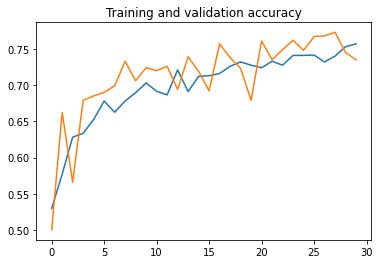

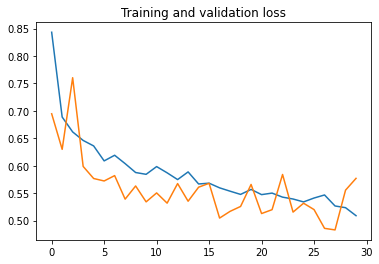

In [64]:
diagnostic_learning_curves() 

Much better! We are no longer overfitting, and we have gained ~3 validation accuracy percentage points (see the green line in the top chart). In fact, judging by our training profile, we could keep fitting our model for 30+ more epochs and we could probably get to ~80%!

In [65]:
# Evaluation
model.evaluate(validation_generator)

50/50 [==============================] - 9s 169ms/step - loss: 0.5769 - acc: 0.7350


[0.5769079923629761, 0.7350000143051147]

In [ ]:
# Prediction
# y_proba = model.predict(validation_generator) 
y_proba
# pd.Series(y_proba.flatten()).head()

In [ ]:
# y_pred = (y_proba > 0.5).astype('int32')
y_pred

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff3f00ee3d0>)

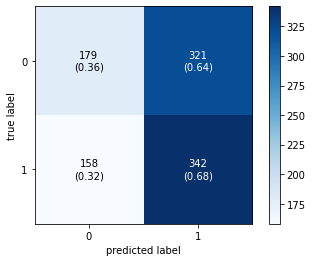

In [73]:
class_names=['cat','dog']
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(validation_generator.classes, y_pred)
conf_mat
plot_confusion_matrix(conf_mat=conf_mat,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True
                                # class_names=class_names
                      )